<a href="https://colab.research.google.com/github/Fraquia/PELU-custom-activation-function/blob/main/PELU_activation_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing a custom activation function

**Author**: *Emanuele Fratocchi*

**Mail**: *emanuele.fratocchi90@gmail.com*


In [ ]:
import tensorflow as tf
from tensorflow import keras

### Introduction

The **exponential linear unit** (ELU) is an activation function defined as [1]:

$$
\phi(x) =
\Biggl\{ 
\begin{align} 
x & \;\; \text{ if } x \ge 0 \\
\alpha \left(\exp\left(x\right)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$

where $\alpha$ is a hyper-parameter. The function is implemented in `tf.keras.layers.ELU` (see the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ELU)).

The **parametric ELU** (PELU) extends the ELU activation function as [2]:

$$
\phi(x) =
\Biggl\{ 
\begin{align} 
\frac{\alpha}{\beta}x & \;\; \text{ if } x \ge 0 \\
\alpha \left(\exp\Bigl(\frac{x}{\beta}\Bigr)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$

where the major difference is that $\alpha,\beta > 0$ are *trainable* parameters, i.e., a pair of $(\alpha, \beta)$ values is trained for each unit in the network.

### Implement the PELU

In TensorFlow, it is possible to implement new layers by subclassing `tf.keras.layers.Layer`:

+ [Making new Layers and Models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models)
+ [Custom layers](https://www.tensorflow.org/tutorials/customization/custom_layers)
+ [tf.keras.layers.Layer (documentation)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)

In [ ]:
class PELU(tf.keras.layers.Layer):
    def __init__(self, units=32):
        super(PELU, self).__init__()
        self.units = units

    def build(self, input_shape): 

        alpha_init = tf.keras.initializers.RandomUniform(minval=3, maxval=None, seed=123)                            #se inziailizzo tropppo basso non funziona nel fit
        self.alpha = tf.Variable(
            initial_value=alpha_init(shape=(self.units,), dtype="float32"), #self.units,
            trainable=True,
        )

        beta_init = tf.keras.initializers.RandomUniform(minval=3, maxval=None, seed=123)
        self.beta = tf.Variable(
            initial_value=beta_init(shape=(self.units,), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
      output = tf.where(inputs>=0, tf.math.multiply(tf.math.divide(self.alpha, self.beta),inputs), tf.math.multiply(tf.math.subtract(tf.math.exp(tf.math.minimum(tf.math.divide(inputs, self.beta),0)),1),self.alpha))

      return output

    def get_config(self):             #to save configuration
        return {"units": self.units} 

### Plotting the function


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



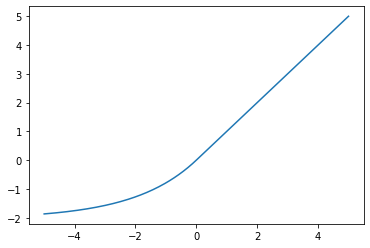

In [ ]:
import matplotlib.pyplot as plt

x_range = tf.linspace(-5, 5, 200) # An equispaced grid of 200 points in [-5, +5]

y_range = tf.convert_to_tensor(pelu(x_range)) 


plt.plot(x_range.numpy(), y_range.numpy())


The derivative of a PELU function with respect to the $\alpha$ parameter is given by [2]:

$$
\frac{d\phi(x)}{d\alpha} =
\Biggl\{ 
\begin{align} 
\frac{x}{\beta} & \;\; \text{ if } x \ge 0 \\
 \left(\exp\Bigl(\frac{x}{\beta}\Bigr)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$

Now using a `tf.GradientTape` object, I compute the derivative above using automatic differentiation, and I check its correctness up to a certain numerical precision.


In [ ]:
#looking to Advanced Automatic Differentiation 

delta = pelu.alpha #needed because the derivative is for alpha

with tf.GradientTape() as tape:
    y=pelu(x_range)

dy_dx = tape.jacobian(y, delta)
grads = tf.reshape(dy_dx, shape=(200,1))

In [ ]:
import math

beta=pelu.beta[0].numpy() # initial beta value 

res_list = []                                  #here are saved numerical results of application of der function of each x value
for j in x_range:
    if j<0:
      res_list.append([math.exp(j/beta)-1]) 
    else:
      res_list.append([j/beta])

der = tf.convert_to_tensor(res_list, dtype='float32') #convert result list to tensor type

tf.reduce_all(tf.abs(grads - res_list) < 1e-4)  #here is checked if two calculus method are similar, if yes return TRUE

<tf.Tensor: shape=(), dtype=bool, numpy=True>

**I also tried the same apporach but now deriving wrt 𝛽**

In [ ]:
delta = pelu.beta  #needed because the derivative is for beta

with tf.GradientTape() as tape:
    y=pelu(x_range)

dy_dx1 = tape.jacobian(y, delta)
grads1 = tf.reshape(dy_dx1, shape=(200,1))

In [ ]:
import math

b=pelu.beta[0].numpy() # initial beta value 
a=pelu.alpha[0].numpy() # initial beta value 

res_list1 = []
for j in x_range:
  if j >=0:
    res_list1.append([(-a*j)/(b**2)])
  else:

    res_list1.append([-a * ((j/(b**2))) * math.exp(j/b)])

der1 = tf.convert_to_tensor(res_list1, dtype='float32') #convert result list to tensor type
tf.reduce_all(tf.abs(grads1 - der1) < 1e-4)  #here is checked if two calculus method are similar, if yes return TRUE

<tf.Tensor: shape=(), dtype=bool, numpy=True>

### PELU in practice

I Considered a simple model built with the PELU activation function, as below. I used data from "Mobile Price Classification" competion on Kaggle.


In [ ]:
#let's call all lybrary needed to deal with our dataset and our model
from sklearn import model_selection
import pandas as pd
import numpy as np
from tensorflow.keras import optimizers


In [ ]:
data_train = pd.read_csv('train_smarphone.csv') #Train set we have to split 

In [ ]:
data_train = data_train.to_numpy()  #to split and work on it

x_tr = data_train[:,:20] #train
y_tr = data_train[:,-1]  #train
y_tr = y_tr.astype(int)

In [ ]:
data_test = pd.read_csv('test_smartphone.csv')

col_list = []
for i,col in data_test.iteritems():  #problem is one column with no label and all Nan values
  if i != 'Unnamed: 0':
    col_list.append(i)

data_test = data_test[col_list]

In [ ]:
x_t = data_test.to_numpy()     #test

In [ ]:
x_tr = tf.keras.utils.normalize(x_tr, axis =1) #scaled from 0 to 1 to simplify computation 
x_t = tf.keras.utils.normalize(x_t, axis =1)   #scaled from 0 to 1 to simplify computation 

In [ ]:
model = tf.keras.Sequential(layers=[
      tf.keras.layers.Dense(20, activation='relu'),            #first layer
      tf.keras.layers.Dense(30),                               #second layer
      PELU(30),                                                #third layer
      tf.keras.layers.Dense(4, activation='softmax')           #output layer
])

adam = optimizers.Adamax(learning_rate=1e-2)

model.compile(loss='sparse_categorical_crossentropy', optimizer=adam ,metrics=['accuracy'])

In [ ]:
model.fit(x =x_tr,y = y_tr,epochs=11)

Epoch 1/11
63/63 [==============================] - 0s 1ms/step - loss: 22.2332 - accuracy: 0.4590
Epoch 2/11
63/63 [==============================] - 0s 1ms/step - loss: 6.0581 - accuracy: 0.5240
Epoch 3/11
63/63 [==============================] - 0s 1ms/step - loss: 4.1471 - accuracy: 0.5415
Epoch 4/11
63/63 [==============================] - 0s 1ms/step - loss: 3.6709 - accuracy: 0.5670
Epoch 5/11
63/63 [==============================] - 0s 1ms/step - loss: 2.7542 - accuracy: 0.5830
Epoch 6/11
63/63 [==============================] - 0s 1ms/step - loss: 2.6588 - accuracy: 0.5915
Epoch 7/11
63/63 [==============================] - 0s 1ms/step - loss: 2.2519 - accuracy: 0.5890
Epoch 8/11
63/63 [==============================] - 0s 1ms/step - loss: 1.9768 - accuracy: 0.6210
Epoch 9/11
63/63 [==============================] - 0s 1ms/step - loss: 2.2934 - accuracy: 0.6110
Epoch 10/11
63/63 [==============================] - 0s 1ms/step - loss: 2.0035 - accuracy: 0.6345
Epoch 11/11
63/63 

In [ ]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_63 (Dense)             (None, 30)                630       
_________________________________________________________________
pelu_19 (PELU)               (None, 30)                60        
_________________________________________________________________
dense_64 (Dense)             (None, 4)                 124       
Total params: 1,234
Trainable params: 1,234
Non-trainable params: 0
_________________________________________________________________


Here is showed my prediction w.r.t the right label, just to have a simple visualization

In [ ]:
prediction = []
for el in (model.predict(x_tr)):
  prediction.append(np.argmax(el))

comp_dataframe = pd.DataFrame()
comp_dataframe['x_pred']=prediction
comp_dataframe['y_label']=y_tr

comp_dataframe.head(10)

,x_pred,y_label
0,2,1
1,1,2
2,2,2
3,2,2
4,1,1
5,0,1
6,3,3
7,0,0
8,1,0
9,0,0


Now let's do the comparison of performances when we apply ReLU instead of PELU

In [ ]:
model_relu = tf.keras.Sequential(layers=[
      tf.keras.layers.Dense(20, activation='relu'),            #first layer
      tf.keras.layers.Dense(30),                               #second layer
      tf.keras.layers.ReLU(30),                                 #third layer
      tf.keras.layers.Dense(4, activation='softmax')           #output layer
])

adam = optimizers.Adamax(learning_rate=1e-2)

model_relu.compile(loss='sparse_categorical_crossentropy', optimizer=adam ,metrics=['accuracy'])

model_relu.fit(x =x_tr,y = y_tr,epochs=11)

Epoch 1/11
63/63 [==============================] - 0s 1ms/step - loss: 4.7863 - accuracy: 0.3610
Epoch 2/11
63/63 [==============================] - 0s 1ms/step - loss: 1.2844 - accuracy: 0.4780
Epoch 3/11
63/63 [==============================] - 0s 1ms/step - loss: 1.1957 - accuracy: 0.4960
Epoch 4/11
63/63 [==============================] - 0s 1ms/step - loss: 1.2153 - accuracy: 0.4580
Epoch 5/11
63/63 [==============================] - 0s 1ms/step - loss: 1.1166 - accuracy: 0.4875
Epoch 6/11
63/63 [==============================] - 0s 1ms/step - loss: 1.0565 - accuracy: 0.5035
Epoch 7/11
63/63 [==============================] - 0s 1ms/step - loss: 1.0168 - accuracy: 0.5225
Epoch 8/11
63/63 [==============================] - 0s 1ms/step - loss: 0.9615 - accuracy: 0.5315
Epoch 9/11
63/63 [==============================] - 0s 1ms/step - loss: 0.9531 - accuracy: 0.5475
Epoch 10/11
63/63 [==============================] - 0s 1ms/step - loss: 0.9534 - accuracy: 0.5630
Epoch 11/11
63/63 [

As expected usign Relu on same dataset is shown a lower accuracy performance. We know that basically they have same behaviour as activation functions, acting as linear function when input values are greater than 0. The difference on performances can be underlined knowing that Pelu has alpha and beta parametres that can be trained. This leads to Pelu to fit and perform better on our model.

In [ ]:
model_relu.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_58 (Dense)             (None, 30)                630       
_________________________________________________________________
re_lu (ReLU)                 (None, 30)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 4)                 124       
Total params: 1,174
Trainable params: 1,174
Non-trainable params: 0
_________________________________________________________________


### References

[1] Clevert, D.A., Unterthiner, T. and Hochreiter, S., 2015. [Fast and accurate deep network learning by exponential linear units (ELUs)](https://arxiv.org/abs/1511.07289). arXiv preprint arXiv:1511.07289.

[2] Trottier, L., Gigu, P. and Chaib-draa, B., 2017. [Parametric exponential linear unit for deep convolutional neural networks](https://arxiv.org/abs/1605.09332). In 2017 16th IEEE International Conference on Machine Learning and Applications (ICMLA) (pp. 207-214). IEEE.